In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BarycentricInterpolator
from scipy import linalg as la

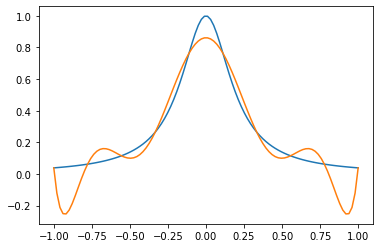

In [5]:
# Problems 1 and 2
def lagrange(xint, yint, points):
    """Find an interpolating polynomial of lowest degree through the points
    (xint, yint) using the Lagrange method and evaluate that polynomial at
    the specified points.

    Parameters:
        xint ((n,) ndarray): x values to be interpolated.
        yint ((n,) ndarray): y values to be interpolated.
        points((m,) ndarray): x values at which to evaluate the polynomial.

    Returns:
        ((m,) ndarray): The value of the polynomial at the specified points.
    """

    def Lj(j, xint, yint, points):
        '''Evaluate L_j at points.'''

        # Compute denominator
        denom = np.product(xint[j-1] - np.delete(xint, j-1))
        
        # Tranpose points to column. From each point subtract
        # each point in xint (except jth), yielding a row for each point in points.
        # Take product along each row. Divide each entry by denom.
        return np.product(points[:,np.newaxis] - np.delete(xint, j-1), axis=1)/denom

    # Stack the n Ljs (each an array of m values where Lj was evaluated),
    # yielding an nxm array. Sum down columns to get get m y-values of interpolation.
    return np.sum(np.array([yint[j-1] * Lj(j, xint, yint, points) for j in range(1, len(xint)+1)]), axis=0)

f = lambda t: 1/(1+25*t**2)
x = np.linspace(-1,1, 10)
y = f(x)

pts = np.linspace(-1, 1, 100)

plt.plot(pts, f(pts))
plt.plot(pts, lagrange(x,y,pts))
plt.show()

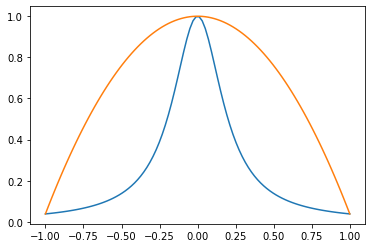

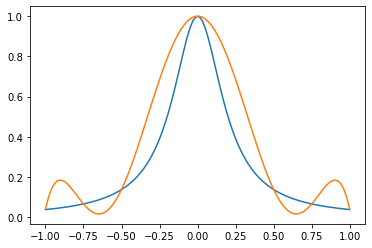

In [6]:
# Problems 3 and 4
class Barycentric:
    """Class for performing Barycentric Lagrange interpolation.

    Attributes:
        w ((n,) ndarray): Array of Barycentric weights.
        n (int): Number of interpolation points.
        x ((n,) ndarray): x values of interpolating points.
        y ((n,) ndarray): y values of interpolating points.
    """

    def __init__(self, xint, yint):
        """Calculate the Barycentric weights using initial interpolating points.

        Parameters:
            xint ((n,) ndarray): x values of interpolating points.
            yint ((n,) ndarray): y values of interpolating points.
        """
        
        # Store interpolating points
        self.xint, self.yint = xint, yint

        ### Use code given on pp. 106-7 in the lab PDF

        # Original number of interpolating points
        self.n = len(self.xint)
        
        # Array for storing barycentric weights
        self.w = np.ones(self.n)

        # Calculate the capacity of the interval
        self.C = (np.max(self.xint) - np.min(self.xint)) / 4

        shuffle = np.random.permutation(self.n-1)
        for j in range(self.n):
            temp = (self.xint[j] - np.delete(self.xint, j)) / self.C
            # Randomize order of product
            temp = temp[shuffle]
            self.w[j] /= np.product(temp)


    def __call__(self, points):
        """Using the calcuated Barycentric weights, evaluate the interpolating polynomial
        at points.

        Parameters:
            points ((m,) ndarray): Array of points at which to evaluate the polynomial.

        Returns:
            ((m,) ndarray): Array of values where the polynomial has been computed.
        """
        
        # Nudge any points found in xint to avoid division by zero
        points[np.isin(points, self.xint)] += 0.000001

        # Each row of base consists of the terms wj/(x-xj) for each x in points
        # Each column consists of the terms wj/(x-xj) for each j
        denom = [self.w[j] / (points - self.xint[j]) for j in range(len(self.xint))]

        # Multiply row_j by yj for each row
        num = self.yint[:,np.newaxis] * denom

        # Sum down columns to get p(x) for each x in points
        return np.sum(num, axis=0) / np.sum(denom, axis=0)

    # Problem 4
    def add_weights(self, xints, yints):
        """Update the existing Barycentric weights using newly given interpolating points
        and create new weights equal to the number of new points.

        Parameters:
            xint ((m,) ndarray): x values of new interpolating points.
            yint ((m,) ndarray): y values of new interpolating points.
        """
        
        def add_weight(xint, yint):
            '''Add just one weight at a time.'''

            # Update existing weights
            self.w /= self.xint - xint

            # Compute new weight (note multiplying by C**(n-1) since
            # the original weights were scaled this way)
            w = self.C**(self.n-1) / np.product(xint - self.xint)

            # Append new weight to existing list of weights
            self.w = np.append(self.w, w)

            # Add xint, yint to self.xint, self.yint
            self.xint = np.append(self.xint, xint)
            self.yint = np.append(self.yint, yint)
        
        # This isn't the most efficient way to add all the weights and points
        # but oh well... tryin' prioritize ya know
        [add_weight(x, y) for x, y in zip(xints, yints)]


f = lambda t: 1/(1+25*t**2)
x = np.linspace(-1, 1, 3)
y = f(x)

bary = Barycentric(x, y)

pts = np.linspace(-1, 1, 100)

plt.plot(pts, f(pts))
plt.plot(pts, bary(pts))
plt.show()

new_x = np.array([-0.5, 0.5, 0.75, -0.75])
bary.add_weights(new_x, f(new_x))

plt.plot(pts, f(pts))
plt.plot(pts, bary(pts))
plt.show()

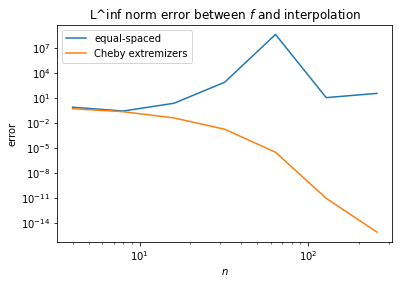

In [72]:
# Problem 5
def prob5():
    """For n = 2^2, 2^3, ..., 2^8, calculate the error of intepolating Runge's
    function on [-1,1] with n points using SciPy's BarycentricInterpolator
    class, once with equally spaced points and once with the Chebyshev
    extremal points. Plot the absolute error of the interpolation with each
    method on a log-log plot.
    """
    
    # Domain
    a, b = -1, 1
    NUM_POINTS_DOMAIN = 400
    domain = np.linspace(a, b, 400)

    # Values of n
    max_exponent = 8
    N = 2**np.arange(2, max_exponent + 1)

    # Runge's function
    f = lambda t: 1/(1+25*t**2)

    def test_plot(run=False):
        '''Test by plotting for various values of n=2**j'''

        # Return if run is False
        if not run:
            return

        J = {2, 4}
        if np.log2(n) in J:
            # Plot f, equal, Cheby
            plt.plot(domain, f(domain), label='$f$')
            plt.plot(domain, equal(domain), label='equal-spaced pts')
            plt.plot(domain, cheby(domain), label='Cheby extremizers')

            # Title, legend, show
            plt.title(f'$n=2^{{{int(np.log2(n))}}}={n}$')
            plt.legend()
            plt.show()

    equal_error = list()
    cheby_error = list()

    # Iterate through n-values
    for n in N:
        # Interpolate at equal-spaced points
        equal_pts = np.linspace(a, b, n)
        equal = BarycentricInterpolator(equal_pts)
        equal.set_yi(f(equal_pts))
        
        # Interpolate at Chebyshev extremizers
        cheby_pts = np.array([1/2*(a+b + (b-a)*np.cos(j*np.pi/n)) for j in range(n+1)])
        cheby = BarycentricInterpolator(cheby_pts)
        cheby.set_yi(f(cheby_pts))
        
        # Test the function and polynomials
        test_plot(run=False)
        
        # Record errors
        equal_error.append(la.norm(f(domain) - equal(domain), ord=np.inf))
        cheby_error.append(la.norm(f(domain) - cheby(domain), ord=np.inf))

    # Plot
    plt.loglog(N, equal_error, label='equal-spaced')
    plt.loglog(N, cheby_error, label='Cheby extremizers')

    # Label axes, legend, title, show
    plt.xlabel('$n$')
    plt.ylabel('error')
    plt.legend()
    plt.title('L^inf norm error between $f$ and interpolation')
    plt.show()

prob5()

In [85]:
# Problem 6
def chebyshev_coeffs(f, n):
    """Algorithm 9.1 in Volume 2
    
    Obtain the Chebyshev coefficients of a polynomial that interpolates
    the function f at n points.

    Parameters:
        f (function): Function to be interpolated.
        n (int): Number of points at which to interpolate.

    Returns:
        coeffs ((n+1,) ndarray): Chebyshev coefficients for the interpolating polynomial.
    """

    # Compute the y_j
    y = np.cos((np.pi * np.arange(2*n)) / n)

    # Sample f at the y_j
    samples = f(y)

    # Compute the coefficients
    coeffs = np.real(np.fft.fft(samples))[:n+1] / n
    coeffs[0] /= 2
    coeffs[n] /= 2

    return coeffs

### Test
# Define f(x) = -3 + 2x^2 - x^3 + x^4 by its (ascending) coefficients
f = lambda x: -3 + 2*x**2 - x**3 + x**4
pcoeffs = [-3, 0, 2, -1, 1]

# NumPy's coeffs
ccoeffs = np.polynomial.chebyshev.poly2cheb(pcoeffs)

# My function's coeffs with degree given by len(pcoeffs)+1
coeffs = chebyshev_coeffs(f, len(pcoeffs) + 1)

# The following callable objects are equivalent to f()
fpoly = np.polynomial.Polynomial(pcoeffs)
fcheb = np.polynomial.Chebyshev(ccoeffs)

# My function's Chebyshev interpolation
cheb = np.polynomial.Chebyshev(coeffs)

# Domain to test on
domain = np.linspace(-1, 1, 5)

print(fpoly(domain))
print(fcheb(domain))
print(cheb(domain))

[ 1.     -2.3125 -3.     -2.5625 -1.    ]
[ 1.     -2.3125 -3.     -2.5625 -1.    ]
[ 1.     -2.3125 -3.     -2.5625 -1.    ]


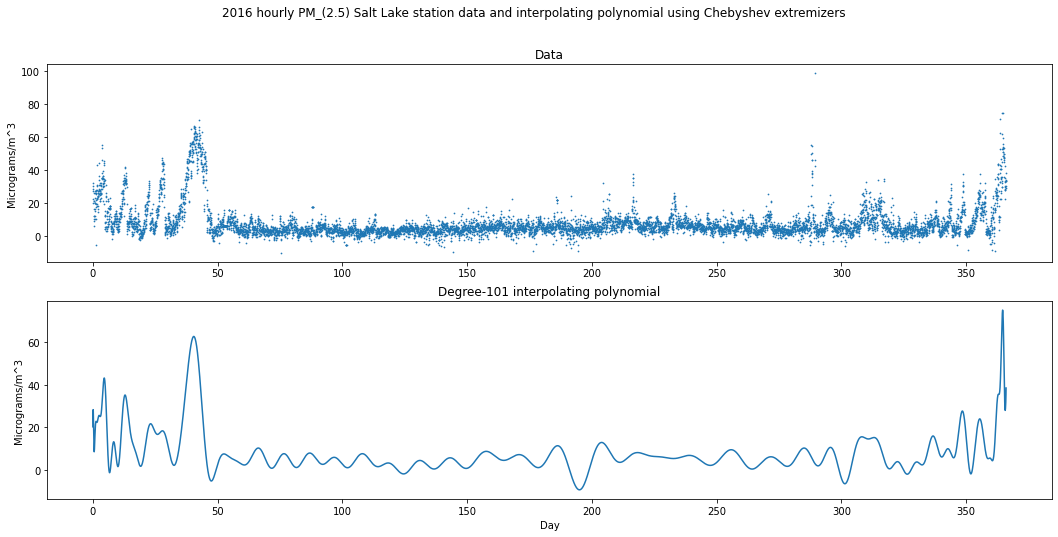

In [7]:
# Problem 7
def prob7(n):
    """Interpolate the air quality data found in airdata.npy using
    Barycentric Lagrange interpolation. Plot the original data and the
    interpolating polynomial.

    Parameters:
        n (int): Number of interpolating points to use.
    """

    # Load data
    data = np.load('airdata.npy')
    
    # Use code from lab PDF to interpolate data at n+1 Chebyshev extremizers
    fx = lambda a, b, n: .5*(a+b + (b-a) * np.cos(np.arange(n+1) * np.pi / n))
    a, b = 0, 366 - 1/24
    domain = np.linspace(0, b, 8784)
    points = fx(a, b, n)
    temp = np.abs(points - domain.reshape(8784, 1))
    temp2 = np.argmin(temp, axis=0)
    poly = Barycentric(domain[temp2], data[temp2])

    # Get figure
    fig, axs = plt.subplots(2, 1, figsize=(18, 8))

    # Plot data
    axs[0].scatter(domain, data, s=0.5)
    axs[0].set_title('Data')

    # Plot polynomial
    axs[1].plot(domain, poly(domain))
    axs[1].set_title(f'Degree-{n+1} interpolating polynomial')

    # Label, title, show
    axs[0].set_ylabel('Micrograms/m^3')
    axs[1].set_ylabel('Micrograms/m^3')
    axs[1].set_xlabel('Day')
    plt.suptitle('2016 hourly PM_(2.5) Salt Lake station data and interpolating polynomial using Chebyshev extremizers')
    plt.show()

prob7(100)